# Simple 1/V estimator
Source: doi:10.1093/mnras/stw756 (page 7)

## Imports, initial values

In [92]:
import numpy as np
from astropy.coordinates import Distance
from astropy.table import Table, hstack
from astropy.cosmology import Planck18
from astropy.coordinates import Distance
from astropy import units as u
import astropy.constants as asc
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import corner
import arviz as az

from astropy.modeling.models import Schechter1D
from astropy.modeling import models, fitting

Complete Sky area in deg^2

In [2]:
omega_sky = 41253 #

In [3]:
min_ra = 160.0
min_dec = -8
max_ra = 180.0
max_dec = 2
buffer = 2.0

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 199.47 sqdeg


## Functions

define the functions that calculate the V_max & luminosity limit

In [4]:
def V_max(omega_s, z_min, z_max_lum):
    """
    Description: Calculates the maximum Volume in which the source could have been detected in: corrects for the so-called "Malmquist-bias"
    (faint objects, which usually also means low mass objects, will only be covered in a survey within a smaller volume than bright and high-mass
    objects)
    
    Params:
    omega_s: surface area covered by the complete data
    z_min: lower redshift limit of sample
    z_max_lum: maximum redshift determined for for object based on luminosity and its completeness 
    (i.e. maximum redshift at which the source with luminosity l would no longer be part of the sample)
    
    """
    z_max = min(z_max_data, z_max_lum)
    return 4/3*np.pi * omega_s/omega_sky * (Distance(z=z_max, cosmology=Planck18)**3-Distance(z=z_min, cosmology=Planck18)**3)

In [5]:
def lum_lim(lum, m_lim, m):
    """
    Calculate the luminosity a source would have if its magnitude was equal to the DESI magnitude limit (have to research the value)
    
    Params:
    - lum: luminosity of an object
    - m_lim: magnitude limit of the survey
    - m: apparent magnitude of an object
    
    """
    return lum*10**(-0.4*(m_lim-m))

## Load the data & prepare/select

In [6]:
# Release directory path

specprod = 'iron'    # Internal name for most current data release
specprod_dir = '/global/cfs/cdirs/desi/spectro/redux/iron/'
print(specprod_dir)

/global/cfs/cdirs/desi/spectro/redux/iron/


In [7]:
ztile_cat = Table.read(f'{specprod_dir}/zcatalog/zall-tilecumulative-{specprod}.fits', hdu="ZCATALOG")

In [8]:
ztile_cat[200000:200002]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int32,bool,int64,bool
2305843042172556950,main,backup,20220315,20220315,-3.00809916038518e-05,8.17084131088571e-06,0,8122.131242808256,2642.9873816104127 .. 0.0,7926,STAR,K,5,1731.7716519866854,6,134,6134,3336,0,236.1111659842606,2.4452757496874202,6.997798,-4.627603,2015.5,5400.0,2305843009213693952,1,TGT,-144.61711,140.12033,25,0.5627646015238863,568,-1,--,345712,-1,GPSF,0.09782427,-99.0,-99.0,-99.0,0.0,0.0,-99.0,-99.0,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,4423852667484346112,G2,18.6984,19.790138,17.672045,0.82504624,G,25,2,0,2305843009213693952,0,288230376151711744,0,0,0,0,0,0,0,0,0,0,0,0,0,236.1111659842606,2.4452757496874202,40280,2,855.4842,2,1,0.00330267,0.004675114,0.0013395663,0.0014562567,236.11117934202923,0.04800739,2.445270189679835,0.0077114785,0.7914041,-144.5933,140.08015,12.523476,0.0053837355,2.5068247,3.1788597,33.164173,19.253931,0.122836754,0.0615563,620.75806,1.7215315,123.98336,0.0015768304,136.13423,911.63226,0.394868,2.4228117,9.204132e-07,6.9117856,1.8511989e-07,0.0,311.3585,1.4048325e-06,1.1787453,3.1866295,633.28156,8.6387005,126.49019,3.1804366,480.6569,930.88617,1.69645,5.6709976,1,True,0,False,1,True
2305843042176741438,main,backup,20220315,20220315,-0.00019829921610947787,3.6222601546171266e-07,0,93622.25726952829,885048.021980

In [338]:
ztile_cat.keep_columns(['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZERR', 'ZWARN', 'TARGET_RA', 'TARGET_DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'LASTNIGHT', 'SPECTYPE'])

In [165]:
ztile_cat = ztile_cat[ztile_cat["PROGRAM"] == "bright"]

In [166]:
len(ztile_cat)

228423

In [167]:
ztile_cat = ztile_cat[ztile_cat['ZWARN']==0]

In [168]:
ztile_cat = ztile_cat[ztile_cat['Z']>=0]

In [169]:
ztile_cat = ztile_cat[ztile_cat["FLUX_Z"] > 0.0]

In [170]:
ztile_cat = ztile_cat[ztile_cat["FLUX_R"] > 0.0]

In [171]:
ztile_cat = ztile_cat[ztile_cat["FLUX_G"] > 0.0]

In [172]:
ii = ztile_cat['TARGET_RA']>(min_ra)
ii &= ztile_cat['TARGET_RA']<(max_ra)
ii &= ztile_cat['TARGET_DEC']>(min_dec)
ii &= ztile_cat['TARGET_DEC']<(max_dec)

ztile_cat = ztile_cat[ii]

In [173]:
len(ztile_cat)

228423

In [174]:
ztile_cat = ztile_cat[ztile_cat["SPECTYPE"] == "GALAXY"]

In [175]:
len(ztile_cat)

228423

### Calculate the apparent and absolute magnitudes from the given Fluxes (app mag both r and z-band flux, to correct the z limit() with a Planck Cosmology

In [176]:
# calculate the absolute and apparent magnitude of every galaxy (Planck Cosmology)
app_mag_z = np.array([22.5-2.5*np.log10(ztile_cat["FLUX_Z"][q]) for q in range(len(ztile_cat["FLUX_Z"]))])
app_mag_r = np.array([22.5-2.5*np.log10(ztile_cat["FLUX_R"][q]) for q in range(len(ztile_cat["FLUX_R"]))])
app_mag_g = np.array([22.5-2.5*np.log10(ztile_cat["FLUX_G"][q]) for q in range(len(ztile_cat["FLUX_G"]))])

abs_mag_z = [(app_mag_z[q] - 5*np.log10(Distance(z=ztile_cat["Z"][q], cosmology=Planck18)/u.Mpc*10**6)+5).value for q in range(len(ztile_cat["FLUX_Z"]))]
abs_mag_r = [(app_mag_r[q] - 5*np.log10(Distance(z=ztile_cat["Z"][q], cosmology=Planck18)/u.Mpc*10**6)+5).value for q in range(len(ztile_cat["FLUX_R"]))]

In [332]:
np.min(abs_mag_r)

-29.320545068393635

In [337]:
np.sort(abs_mag_r)[::-1]

array([  4.71597771,   0.29235904,  -0.04359701, ..., -28.63984317,
       -28.75795332, -29.32054507])

In [177]:
corner_plot_data = {"G": app_mag_g, "R": app_mag_r, "Z": app_mag_z}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": app_mag_r>19.5})

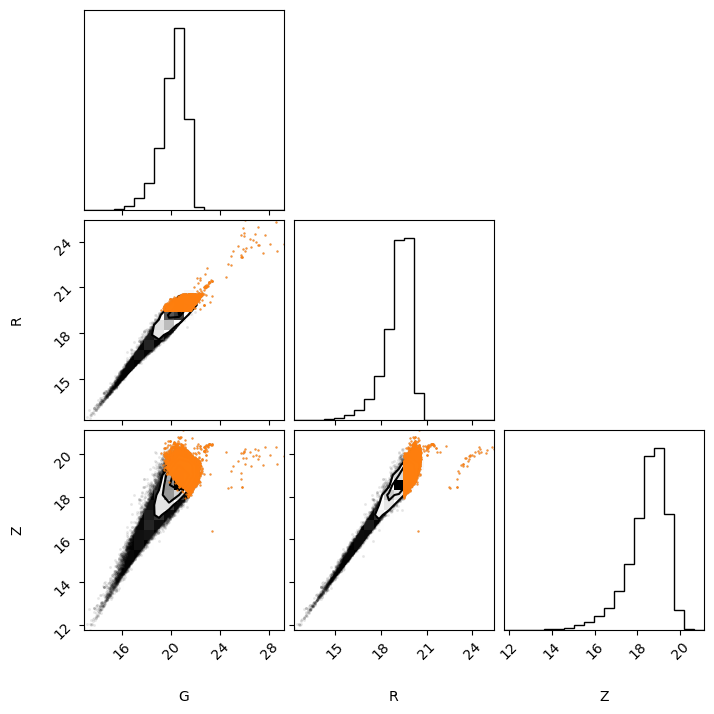

In [178]:
figure = corner.corner(corner_plot_data, divergences = True)

In [179]:
diff = [app_mag_r[q]-app_mag_z[q] for q in range(len(app_mag_r))]

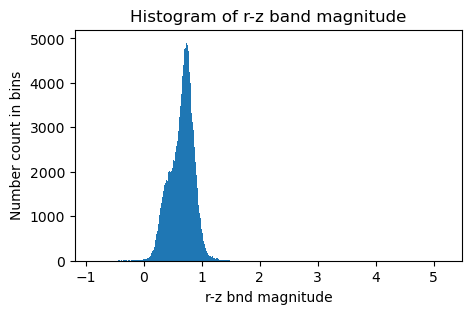

In [180]:
fig, ax = plt.subplots(figsize = (5,3))

ax.hist(diff, bins='auto')
ax.set_xlabel("r-z bnd magnitude")
ax.set_ylabel("Number count in bins")
plt.title("Histogram of r-z band magnitude")
plt.show()

In [181]:
avg_diff = np.mean(diff)

In [182]:
avg_diff

0.6518473640915409

In [183]:
# However, since we only look at the z-band we need to correct the solar luminosity
# Calculation from here: https://astronomy.stackexchange.com/questions/25126/how-to-calculate-luminosity-in-g-band-from-absolute-ab-magnitude-and-luminosity
lmbda_z = 920*10**(-9) #in  m
del_lambda_z = 160*10**(-9) #in m
del_v_z = (asc.c*lmbda_z/(del_lambda_z**2)).value # this is in /s now

lmbda_r = 640*10**(-9) #in  m 5600A-7200A -> 6400A median
del_lambda_r = 160*10**(-9) #in m
del_v_r = (asc.c*lmbda_r/(del_lambda_r**2)).value # this is in /s now


m_sun_z = -27.56 # in z-band: http://mips.as.arizona.edu/~cnaw/sun.html (DES filter)
m_sun_r = -27.12 # in r-band: http://mips.as.arizona.edu/~cnaw/sun.html (DES filter)

f_v_z = 10**((-48.6-m_sun_z)/2.5) # in erg/(cm^2 s Hz)
f_v_r = 10**((-48.6-m_sun_r)/2.5) # in erg/(cm^2 s Hz)

dist_sun = 1.496*10**13 # in cm

L_sun_z = f_v_z*del_v_z*4*np.pi*dist_sun**2 # this is  in erg/s, convert to W in function declaration
L_sun_r = f_v_r*del_v_r*4*np.pi*dist_sun**2
# the value is roughly half of the full bolometric value... not sure if this makes sense
print(L_sun_z, L_sun_r)

def lum_z(M):
    return L_sun_z*10**(-7)*10**(-0.4*M)*u.W

def lum_r(M):
    return L_sun_r*10**(-7)*10**(-0.4*M)*u.W

1.1626302434227456e+35 5.393041505438385e+34


In [184]:
lums_z = [lum_z(abs_mag_z[q]).value for q in range(len(abs_mag_z))]

In [185]:
lums_r = [lum_r(abs_mag_r[q]).value for q in range(len(abs_mag_r))]

In [186]:
offset = 0

In [187]:
m_limit_z = 19.5-avg_diff+offset # r-band magnitude limit for BGS Bright, would need to convert it to z-band magnitude

In [188]:
m_limit_z

18.84815263590846

In [189]:
m_limit_r = 19.5

In [190]:
lumin_limits_r = [lum_lim(lums_r[q], m_limit_r, app_mag_r[q]) for q in range(len(ztile_cat["FLUX_R"]))]

In [191]:
lumin_limits_z = [lum_lim(lums_z[q], m_limit_z, app_mag_z[q]) for q in range(len(ztile_cat["FLUX_Z"]))]

In [192]:
# cornerplot (corner, chainconsumer) to see whether I miss peculiar galaxies
# redshift

In [339]:
ztile_cat = hstack([ztile_cat, Table({"APP_MAG_G": app_mag_g}),  Table({"APP_MAG_R": app_mag_r}), Table({'APP_MAG_Z': app_mag_z}), Table({"LUM_Z": lums_z}), Table({"LUM_R": lums_r}), Table({'LUM_LIMIT_Z': lumin_limits_z}), Table({'LUM_LIMIT_R': lumin_limits_r})])

In [340]:
ztile_cat

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627775337824625,main,bright,20211203,0.13764590720371164,3.138398346518236e-05,0,GALAXY,160.26516984509954,-0.6169891390880035,18.83545,51.795795,107.864204,19.312559962272644,18.2142636179924,17.417806386947632,5.647072512638723e+36,1.2578609033628081e+36,1.512463368189812e+36,3.848912746088073e+35
39627769298028466,main,bright,20211203,0.2817386734692243,3.1591015286591765e-05,0,GALAXY,160.32678007762797,-0.7009874345328915,4.700197,13.230762,27.53629,20.81970974802971,19.696037769317627,18.90023648738861,7.117260591982475e+36,1.586296994093595e+36,7.467004413149084e+36,1.9002012918344343e+36
39627775333634331,main,bright,20211203,0.13458266255484935,2.6267345434881147e-05,0,GALAXY,160.22171516984815,-0.6094808182128068,6.9386554,17.924074,42.162964,20.39681166410446,19.36640828847885,18.4376722574234,2.102104565744086e+36,4.145262615741223e+35,1.4403305226462392e+36,3.665349273105225e+35
39627769298026862,main,bright,20211203,0.13299025612216608,7.00164724165495e-05,0,GALAXY,160.26156628507124,-0.7357844162293757,8.49183,20.583942,37.838287,20.177496820688248,19.21617865562439,18.555171191692352,1.8384122872717112e+36,4.6390822771615235e+35,1.4036225485234346e+36,3.571934918446551e+35
39627787413227120,main,bright,20211203,0.13477296048907014,3.583645968152769e-06,0,GALAXY,160.07077291874026,-0.01671600137374464,21.668411,32.528183,43.264362,19.16043221950531,18.719350397586823,18.409674167633057,2.1636403922310253e+36,7.545825107856472e+35,1.4447532936829242e+36,3.67660432904519e+35
39627769298027878,main,bright,20211203,0.1919126971419605,2.206269425513075e-05,0,GALAXY,160.30116444104704,-0.6576801019874786,11.47951,32.69794,69.04125,19.850191473960876,18.713698983192444,17.902228236198425,7.503124258895577e+36,1.6483369217921264e+36,3.1395859648750525e+36,7.989609991089905e+35
39627769298027257,main,bright,20211203,0.13657319228018894,5.620423916466128e-05,0,GALAXY,160.27495064273108,-0.7181123946679159,7.617141,19.900192,38.26928,20.29552012681961,19.252856969833374,18.54287415742874,1.9697679250053792e+36,4.751317833182694e+35,1.486975010078858e+36,3.784050040337051e+35
39627769293834545,main,bright,20211203,0.22811114966831142,2.5952989423481735e-05,0,GALAXY,160.10558163742888,-0.6667095058494888,3.2750242,7.7390156,14.049797,21.21196374297142,20.27828574180603,19.63082492351532,2.2477918795796098e+36,5.743331938598757e+35,4.621947552117916e+36,1.1761919805296508e+36
39627769298027769,main,bright,20211203,0.13891779011883018,2.0856369110834963e-05,0,GALAXY,160.2959805373684,-0.7673462975645843,4.0475388,8.019296,13.393776,20.982022434473038,20.239659398794174,19.68274235725403,7.153707573501713e+35,1.986810805433585e+35,1.5430040706516382e+36,3.926632644270133e+35


In [341]:
#ztile_cat_r_cut = ztile_cat[ztile_cat["APP_MAG_R"] < m_limit_r]

In [342]:
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]< 0.6]
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]> 0.1]

In [343]:
ztile_cat_r_cut = ztile_cat_r_cut[ztile_cat_r_cut["Z"] > 0.1]

In [344]:
z_max_data = np.max(ztile_cat_r_cut["Z"])
z_min_data = np.min(ztile_cat_r_cut["Z"])
print("z min and max in sample: ", z_min_data, z_max_data)

z min and max in sample:  0.10000133480204226 1.6972743730127822


In [345]:
ztile_cat_r_cut

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627775337824625,main,bright,20211203,0.13764590720371164,3.138398346518236e-05,0,GALAXY,160.26516984509954,-0.6169891390880035,18.83545,51.795795,107.864204,19.312559962272644,18.2142636179924,17.417806386947632,5.647072512638723e+36,1.2578609033628081e+36,1.512463368189812e+36,3.848912746088073e+35
39627775333634331,main,bright,20211203,0.13458266255484935,2.6267345434881147e-05,0,GALAXY,160.22171516984815,-0.6094808182128068,6.9386554,17.924074,42.162964,20.39681166410446,19.36640828847885,18.4376722574234,2.102104565744086e+36,4.145262615741223e+35,1.4403305226462392e+36,3.665349273105225e+35
39627769298026862,main,bright,20211203,0.13299025612216608,7.00164724165495e-05,0,GALAXY,160.26156628507124,-0.7357844162293757,8.49183,20.583942,37.838287,20.177496820688248,19.21617865562439,18.555171191692352,1.8384122872717112e+36,4.6390822771615235e+35,1.4036225485234346e+36,3.571934918446551e+35
39627787413227120,main,bright,20211203,0.13477296048907014,3.583645968152769e-06,0,GALAXY,160.07077291874026,-0.01671600137374464,21.668411,32.528183,43.264362,19.16043221950531,18.719350397586823,18.409674167633057,2.1636403922310253e+36,7.545825107856472e+35,1.4447532936829242e+36,3.67660432904519e+35
39627769298027878,main,bright,20211203,0.1919126971419605,2.206269425513075e-05,0,GALAXY,160.30116444104704,-0.6576801019874786,11.47951,32.69794,69.04125,19.850191473960876,18.713698983192444,17.902228236198425,7.503124258895577e+36,1.6483369217921264e+36,3.1395859648750525e+36,7.989609991089905e+35
39627769298027257,main,bright,20211203,0.13657319228018894,5.620423916466128e-05,0,GALAXY,160.27495064273108,-0.7181123946679159,7.617141,19.900192,38.26928,20.29552012681961,19.252856969833374,18.54287415742874,1.9697679250053792e+36,4.751317833182694e+35,1.486975010078858e+36,3.784050040337051e+35
39627769293836999,main,bright,20211203,0.28314743112105445,5.270605778728687e-05,0,GALAXY,160.20747811643687,-0.7398594651345043,5.2359915,20.66519,43.343533,20.702502727508545,19.211901426315308,18.407689332962036,1.1331701562516258e+37,2.506123318706842e+36,7.552831693259389e+36,1.9220425951893707e+36
39627787413226785,main,bright,20211203,0.13377130957504585,5.181663556964667e-06,0,GALAXY,160.0562153862003,-0.10595802403019254,12.539079,19.833014,27.650469,19.75433588027954,19.256528317928314,18.895743787288666,1.3605946070332838e+36,4.526964403992008e+35,1.421560036095068e+36,3.617582188985002e+35
39627787413228010,main,bright,20211203,0.1391012047609144,5.262625606954963e-05,0,GALAXY,160.10640563198723,-0.1189626488410825,10.3892,27.175236,51.205555,19.958544671535492,18.91456663608551,18.22670727968216,2.742780860333398e+36,6.752110084469866e+35,1.5474369674853793e+36,3.937913468311444e+35


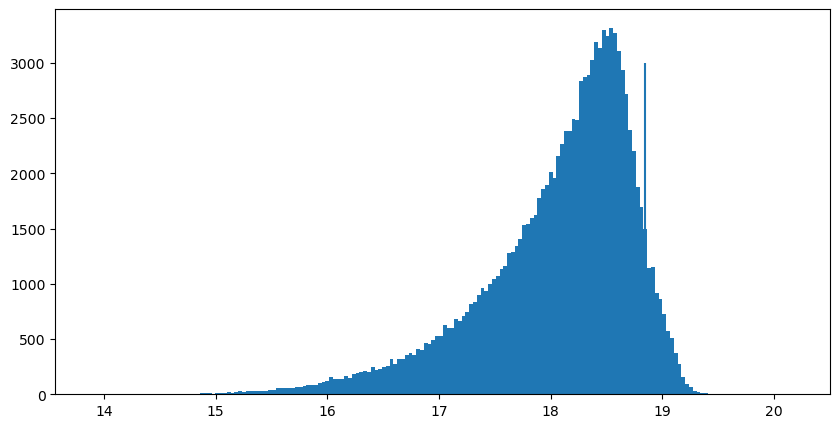

In [346]:
fig, ax = plt.subplots(figsize = (10,5))

ax.hist(ztile_cat_r_cut["APP_MAG_Z"], bins = "auto")
ax.vlines(m_limit_z, 0, 3000)

plt.show()

In [347]:
corner_plot_data = {"G": ztile_cat_r_cut["APP_MAG_G"], "R": ztile_cat_r_cut["APP_MAG_R"], "Z": ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

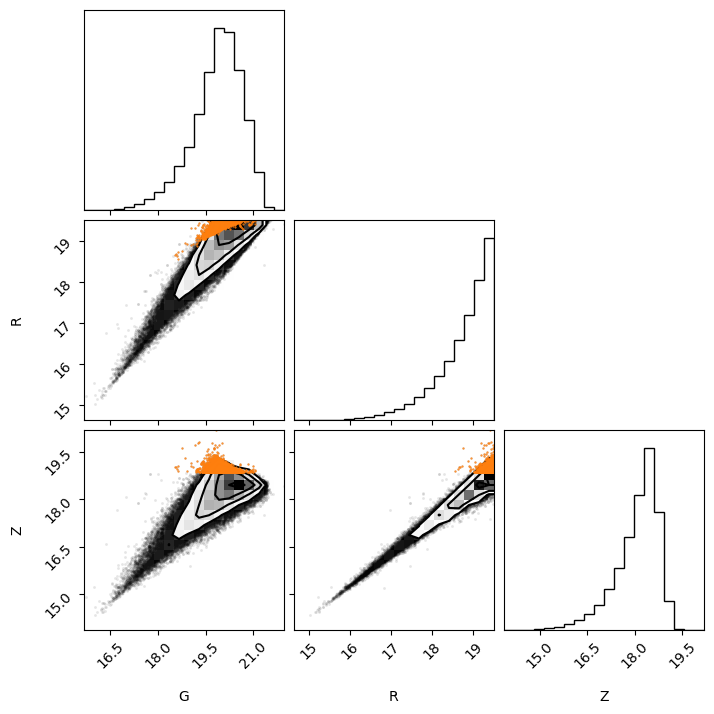

In [348]:
figure = corner.corner(corner_plot_data, divergences = True)

In [349]:
corner_plot_data = {"G-R": ztile_cat_r_cut["APP_MAG_G"]-ztile_cat_r_cut["APP_MAG_R"], "R-Z": ztile_cat_r_cut["APP_MAG_R"] - ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

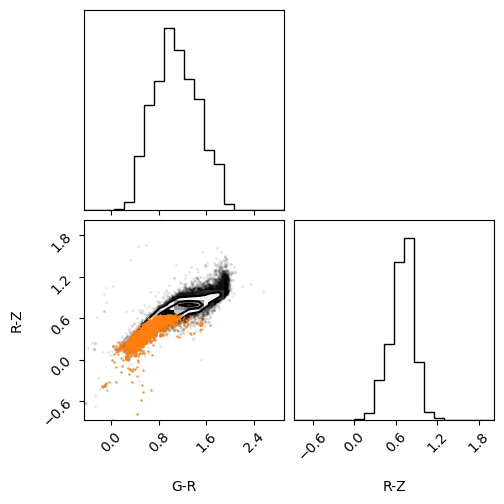

In [350]:
figure = corner.corner(corner_plot_data, divergences = True)

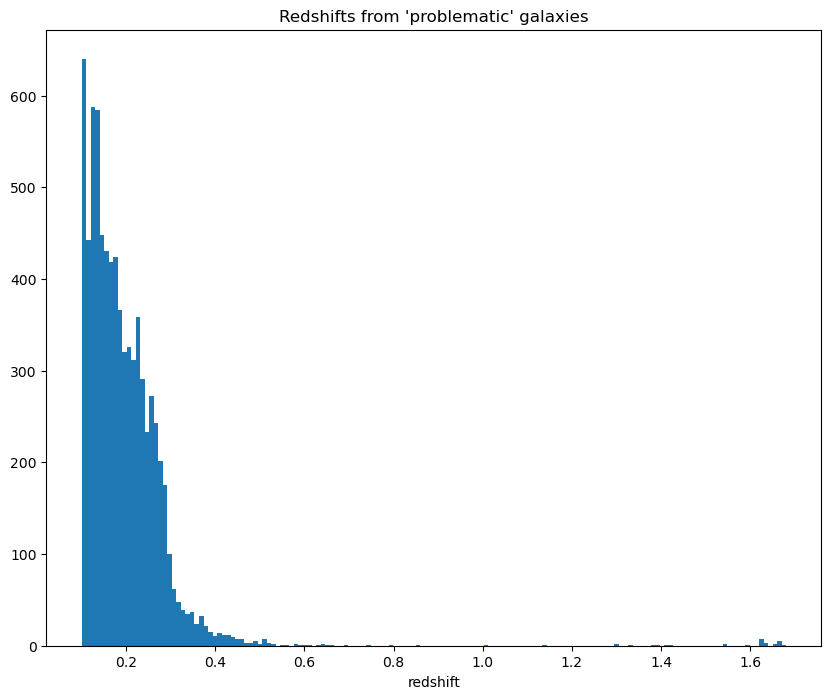

In [351]:
fig, ax = plt.subplots(figsize = (10,8))

ax.hist(ztile_cat_r_cut["Z"][ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z], bins = "auto")
ax.set_xlabel("redshift")
plt.title("Redshifts from 'problematic' galaxies")
plt.show()

In [352]:
len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z]), len(ztile_cat_r_cut), len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z])/len(ztile_cat_r_cut)

(64918, 116476, 0.5573508705656101)

In [353]:
ztile_cat_grouped_by_AppMag = ztile_cat_r_cut.group_by("APP_MAG_R")

In [354]:
ztile_cat_grouped_by_AppMag

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627781692196799,sv3,bright,20210501,0.10747144463925516,1.818968440523567e-05,0,GALAXY,179.08357626336823,-0.20556252174575723,541.38214,1389.6007,2806.7297,15.666240453720093,14.642775058746338,13.87949824333191,8.61773990468288e+37,1.9791321912999927e+37,8.870163504853628e+35,2.257276843311409e+35
39627799668986847,main,bright,20220212,0.1006116447293789,1.8389733472447712e-05,0,GALAXY,170.68695580001403,0.4622516854532926,397.39447,964.94586,1790.3483,16.001945734024048,15.038742423057556,14.367656111717224,4.774379189579045e+37,1.1936432063103743e+37,7.704035916079565e+35,1.9605210054910674e+35
39627696866593362,main,bright,20220312,0.10787162036977999,1.732253838084697e-05,0,GALAXY,161.8435959282249,-3.7522345991569006,367.48782,867.08966,1656.368,16.08689248561859,15.154839754104614,14.452108144760132,5.126315868907464e+37,1.2448151508742872e+37,8.941030290635416e+35,2.2753110040591256e+35
39627654869030068,main,bright,20220213,0.11658788477000842,2.652876814398194e-05,0,GALAXY,172.70212038918515,-5.546945014914002,318.821,841.4778,1642.8849,16.241132616996765,15.187393426895142,14.460982084274292,6.00725382936969e+37,1.4272616365497895e+37,1.0563498191062616e+36,2.6881962026968376e+35
39627835937129473,main,bright,20220329,0.10964324775449051,2.4118651038848044e-05,0,GALAXY,172.29901340133625,1.9960480131734615,331.49387,825.2125,1552.931,16.198811531066895,15.208585262298584,14.522119760513306,4.976873883016478e+37,1.2267684026693105e+37,9.258560854583324e+35,2.356116097296821e+35
39627636892239451,main,bright,20211212,1.150921868512021,8.693763568456872e-05,0,GALAXY,176.31080202398348,-6.2916661793181765,516.65674,820.00757,1079.5172,15.716995000839233,15.215455293655396,14.9169260263443,8.185992649158167e+39,2.884375447176123e+39,2.190688893796263e+38,5.574859255029472e+37
39627715157952077,main,bright,20220212,0.11734826220185841,1.9543843638868422e-05,0,GALAXY,173.3306204195519,-3.0137298050366828,329.50845,815.9549,1505.5103,16.205333471298218,15.220834612846375,14.555790424346924,5.58246645439903e+37,1.4034617901278286e+37,1.0712263265847267e+36,2.7260538992569005e+35
39627690965208223,main,bright,20220402,0.10369683442097574,1.9161701506552776e-05,0,GALAXY,169.65030677576536,-4.0977914279114325,313.59595,802.2161,1536.7024,16.259073615074158,15.239271521568298,14.533525705337524,4.370921233069445e+37,1.0584413558192536e+37,8.217168791624886e+35,2.091102922822856e+35
39627721256472139,main,bright,20220307,0.12281163842735825,2.461482370244118e-06,0,GALAXY,176.91221065267374,-2.8240357970076695,397.9955,802.09326,1440.4661,16.00030481815338,15.239437818527222,14.603742361068726,5.891496053595742e+37,1.521736840365433e+37,1.1815755105589883e+36,3.006870208366775e+35


In [355]:
ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[::-1]

In [356]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627835916159877,main,bright,20220212,0.23428330596704042,1.443498528161678e-05,0,GALAXY,171.14972043569097,1.92477068287446,7.353448,15.84911,23.749014,20.3337724506855,19.499987959861755,19.060885906219482,4.035351851665228e+36,1.249202178789381e+36,4.908792970050321e+36,1.2491883259921112e+36
39627666977982573,main,bright,20220428,0.20157941103755833,1.083824890052584e-05,0,GALAXY,176.56867538190875,-4.981347833087403,8.609719,15.849189,23.325424,20.162527561187744,19.4999822974205,19.0804260969162,2.8281714242868873e+36,8.914056784326203e+35,3.502798171009178e+36,8.913911444683167e+35
39627823786233784,main,bright,20220202,0.20824350213383092,9.564463444010136e-05,0,GALAXY,168.17077944574612,1.5950422798573112,4.9256334,15.849355,34.00256,20.768844783306122,19.499970972537994,18.67122083902359,4.433535407625294e+36,9.58610704831899e+35,3.7668425060952035e+36,9.585850764483878e+35
39627715116009935,main,bright,20220307,0.2122874558546436,0.00017191232459495677,0,GALAXY,170.87479636907145,-3.1225857124801504,4.6221576,15.849775,32.721992,20.83788812160492,19.49994206428528,18.712900578975677,4.4542964314349503e+36,1.0008169874419087e+36,3.932586581295464e+36,1.000763584506429e+36
39627817830322361,main,bright,20220329,0.13567196470711493,7.6202518639822085e-06,0,GALAXY,173.24658341521794,1.3128592157285623,10.536563,15.849862,22.040632,19.943252503871918,19.4999361038208,19.141939878463745,1.1182669435643109e+36,3.7302603467223355e+35,1.4657516244900027e+36,3.7300408252868616e+35


In [357]:
ztile_cat_grouped_by_AppMag_sel = ztile_cat_grouped_by_AppMag[:int(0.2*len(ztile_cat_grouped_by_AppMag))]

In [358]:
np.max(ztile_cat_grouped_by_AppMag["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag["LUM_R"]), np.max(ztile_cat_grouped_by_AppMag_sel["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag_sel["LUM_R"])

(2.884375447176123e+39,
 1.9522015283545803e+35,
 1.622730592856281e+38,
 1.9522015283545803e+35)

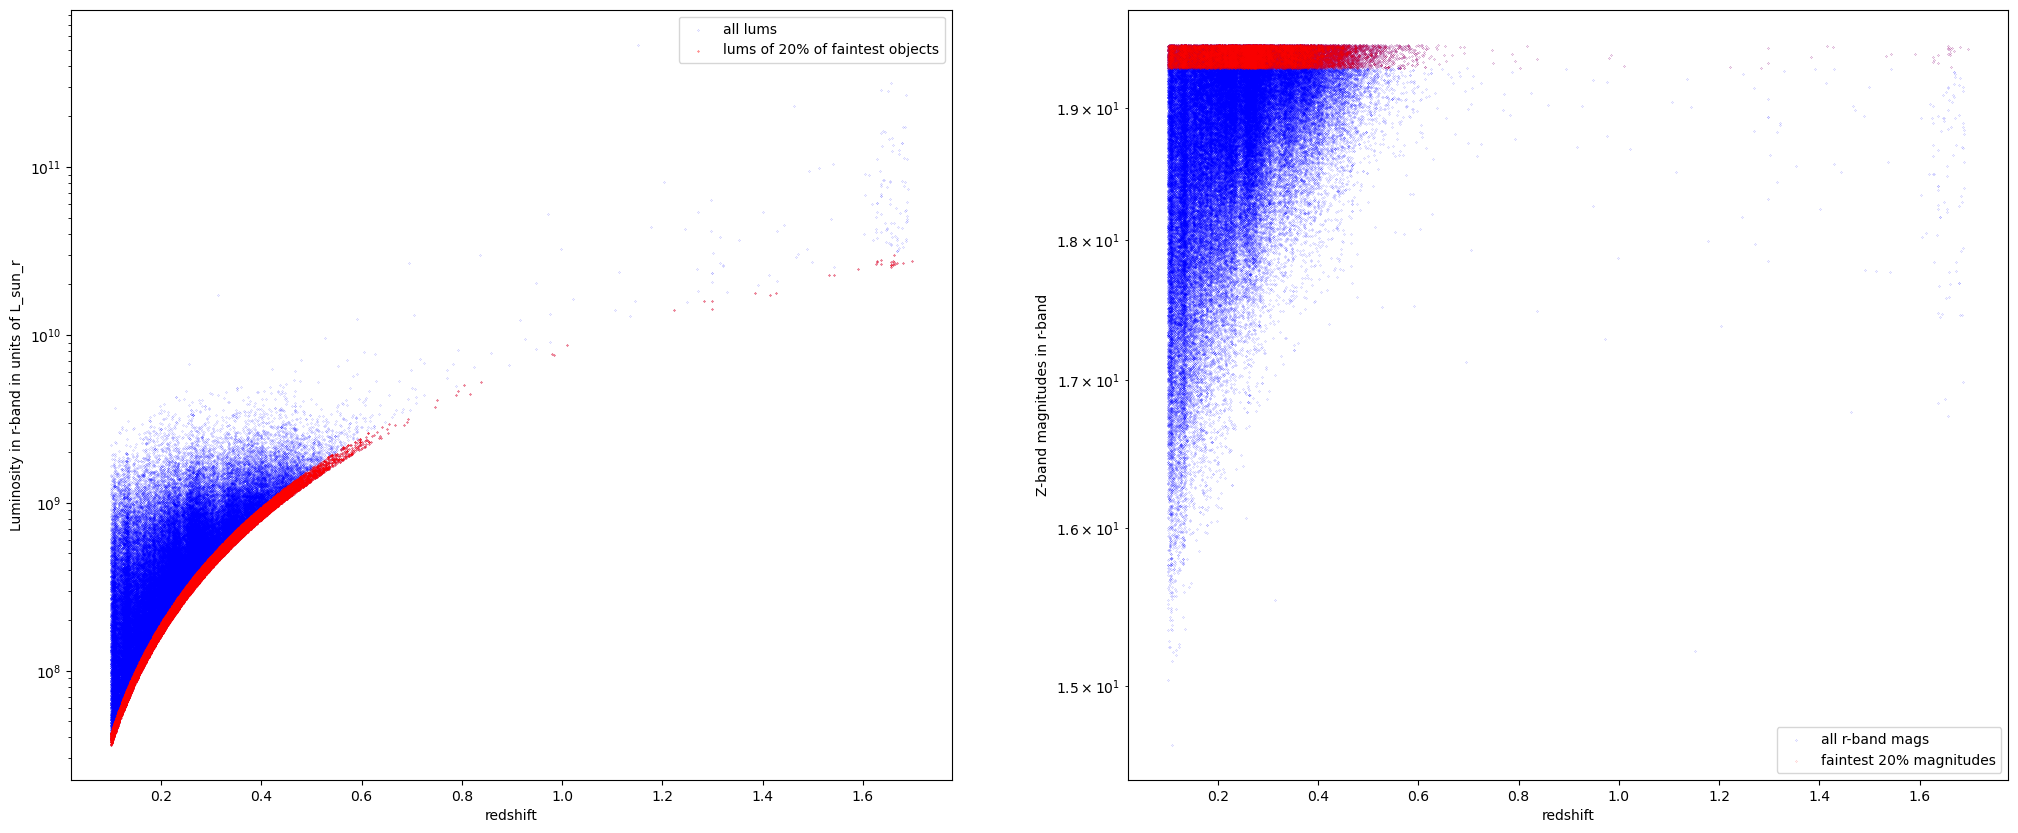

In [359]:
fig, ax = plt.subplots(ncols = 2, figsize = (25,10))

ax[0].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r*10**(-7)), s = 0.01, color = "blue", label = "all lums")
ax[0].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"]/(L_sun_r*10**(-7)), s = 0.1, color = "red", label ="lums of 20% of faintest objects")

ax[1].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["APP_MAG_R"], s = 0.01, color = "blue", label = "all r-band mags")
ax[1].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["APP_MAG_R"], s = 0.01, color = "red", label = "faintest 20% magnitudes")


ax[0].set_xlabel("redshift")
ax[0].set_ylabel("Luminosity in r-band in units of L_sun_r")
ax[0].set_yscale("log")
#ax.set_xlim(0.08,.6)
#ax.set_ylim(10**3,10**5)
ax[0].legend()

ax[1].set_xlabel("redshift")
ax[1].set_ylabel("Z-band magnitudes in r-band")
ax[1].set_yscale("log")
ax[1].legend()

plt.show()

In [360]:
ztile_cat_grouped_by_AppMag_sel

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627835916159877,main,bright,20220212,0.23428330596704042,1.443498528161678e-05,0,GALAXY,171.14972043569097,1.92477068287446,7.353448,15.84911,23.749014,20.3337724506855,19.499987959861755,19.060885906219482,4.035351851665228e+36,1.249202178789381e+36,4.908792970050321e+36,1.2491883259921112e+36
39627666977982573,main,bright,20220428,0.20157941103755833,1.083824890052584e-05,0,GALAXY,176.56867538190875,-4.981347833087403,8.609719,15.849189,23.325424,20.162527561187744,19.4999822974205,19.0804260969162,2.8281714242868873e+36,8.914056784326203e+35,3.502798171009178e+36,8.913911444683167e+35
39627823786233784,main,bright,20220202,0.20824350213383092,9.564463444010136e-05,0,GALAXY,168.17077944574612,1.5950422798573112,4.9256334,15.849355,34.00256,20.768844783306122,19.499970972537994,18.67122083902359,4.433535407625294e+36,9.58610704831899e+35,3.7668425060952035e+36,9.585850764483878e+35
39627715116009935,main,bright,20220307,0.2122874558546436,0.00017191232459495677,0,GALAXY,170.87479636907145,-3.1225857124801504,4.6221576,15.849775,32.721992,20.83788812160492,19.49994206428528,18.712900578975677,4.4542964314349503e+36,1.0008169874419087e+36,3.932586581295464e+36,1.000763584506429e+36
39627817830322361,main,bright,20220329,0.13567196470711493,7.6202518639822085e-06,0,GALAXY,173.24658341521794,1.3128592157285623,10.536563,15.849862,22.040632,19.943252503871918,19.4999361038208,19.141939878463745,1.1182669435643109e+36,3.7302603467223355e+35,1.4657516244900027e+36,3.7300408252868616e+35
39627751249939488,main,bright,20211219,0.17741879029265198,4.038567067795509e-06,0,GALAXY,164.62507716662276,-1.4904943931161718,7.6938553,15.849929,28.825605,20.28463989496231,19.499931633472443,18.850553929805756,2.6320754066270643e+36,6.713351588443035e+35,2.6379031399701054e+36,6.712928876107825e+35
39627678826889600,main,bright,20220202,0.27617559570485434,5.8314291574574656e-05,0,GALAXY,164.7234944064917,-4.579779678579022,4.7597575,15.850132,34.427982,20.806037932634354,19.49991762638092,18.657720983028412,8.501453615449641e+36,1.8155435833936314e+36,7.133793412755478e+36,1.8154058453115433e+36
39627805838803573,sv3,bright,20210412,0.22758025299510903,0.00013580970085046507,0,GALAXY,178.28342115643846,0.7625343731361771,4.905727,15.850238,32.08448,20.77324151992798,19.499910473823547,18.734262585639954,5.1062420726384683e+36,1.1701307463239285e+36,4.5977502802352333e+36,1.170034265233625e+36
39627805838803573,main,bright,20220515,0.22737522444350716,6.494913995492875e-05,0,GALAXY,178.28342115643846,0.7625343731361771,4.905727,15.850238,32.08448,20.77324151992798,19.499910473823547,18.734262585639954,5.0958860518727956e+36,1.1677575924203139e+36,4.5884255367741597e+36,1.1676613070042773e+36


In [361]:
lower_limit_z = np.min(ztile_cat_grouped_by_AppMag["Z"]) # np.min(faint_mags["Z"]) # get the limits of redshift in this sample
upper_limit_z = np.max(ztile_cat_grouped_by_AppMag["Z"]) # np.max(faint_mags["Z"])
delta_z = 0.005
bins = np.arange(lower_limit_z, upper_limit_z, delta_z)
num_of_bins_z = len(bins)

In [362]:
lower_limit_z, upper_limit_z, num_of_bins_z

(0.10000133480204226, 1.6972743730127822, 320)

In [363]:
LUM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin
LUM_LIM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin

cnt = 0
for bins_left_edge in bins[:num_of_bins_z-1]:
    # this is where we select all the galaxies that lie in the z range ([start, stop))
    
    # z-range selection
    ii = ztile_cat_grouped_by_AppMag_sel['Z']>=(bins_left_edge)
    ii &= ztile_cat_grouped_by_AppMag_sel['Z']<(bins_left_edge+delta_z)
    dat = ztile_cat_grouped_by_AppMag_sel[ii]

    # select only z-band luminosity (limit)
    LUM = dat["LUM_R"]
    LUM_LIM = dat["LUM_LIMIT_R"]
    
    # sort this data ascending
    LUM = np.sort(LUM)
    LUM_LIM = np.sort(LUM_LIM)
    
    # impose the same cut as in the paper, at 95%. This is the mass limit value
    LUM_cut = int(0.95*len(LUM))
    LUM_LIM_cut = int(0.95*len(LUM_LIM))

    # if there was no data in this bin, just store a 0
    if len(LUM) == 0:
        LUM = [0]
    if len(LUM_LIM) == 0:
        LUM_LIM = [0]
    
    # now store this luminosity (limit) value for the whole redshift range
    LUM_95[cnt] = LUM[LUM_cut] # this is the 95% lum per bin
    LUM_LIM_95[cnt] = LUM_LIM[LUM_LIM_cut] # this is the "Luminosity Limit" value per bin
    cnt += 1

In [364]:
stop_at = np.argmin(LUM_LIM_95[10:])
if stop_at == 0:
    stop_at = len(LUM_LIM_95)

In [365]:
stop_at

95

Fit values:  6158472608.205646 -593227127.9656457 38232036.653488584


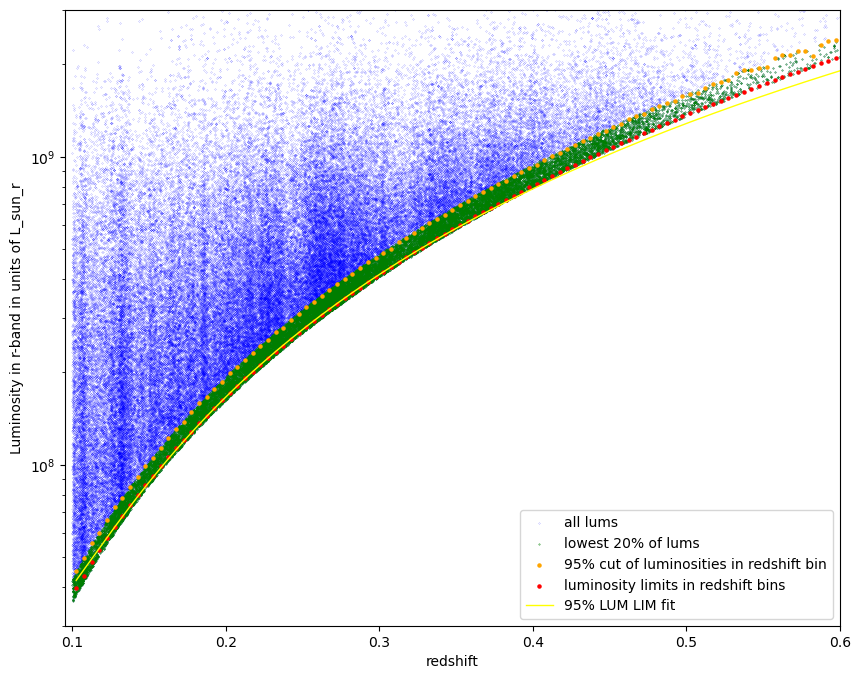

In [366]:
fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r*10**(-7)), s = 0.01, color = "blue", label = "all lums")
ax.scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"]/(L_sun_r*10**(-7)), s = 0.1, color = "green", label ="lowest 20% of lums")

center_z = (bins[:-1] + bins[1:])/2
ax.scatter(center_z, LUM_95/(L_sun_r*10**(-7)), s = 5, color = "orange", label = "95% cut of luminosities in redshift bin")
ax.scatter(center_z, LUM_LIM_95/(L_sun_r*10**(-7)), s = 5, color = "red", label ="luminosity limits in redshift bins")

def poly2d(x, a, b, c):
    return a*x**2 + b*x + c

def poly3d(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

# for the fit to be good, we need to decrease the LUM values, otherwise, they fit doesn't work that well
# normalize_LUM = 10**(7)

coefs_LUM_LIM_95, _ = curve_fit(poly2d, center_z[:int(stop_at/2)], LUM_LIM_95[:int(stop_at/2)]/(L_sun_r*10**(-7)))
print("Fit values: ", coefs_LUM_LIM_95[0], coefs_LUM_LIM_95[1], coefs_LUM_LIM_95[2])

ax.plot(center_z, poly2d(center_z, *coefs_LUM_LIM_95), linewidth = 1, color = "yellow", label = "95% LUM LIM fit")

ax.set_xlabel("redshift")
ax.set_ylabel("Luminosity in r-band in units of L_sun_r")
ax.set_yscale("log")
ax.set_xlim(0.095, 0.6)
ax.set_ylim(3*10**7,3*10**9)
ax.legend()
plt.show()

In [367]:
def poly3d_inverse(x, a, b, c, d):
    # x is (as its the inverse) the y
    
    p = -b/(3*a)
    q = p**3+(b*c-3*a*(d-x))/(6*a**2)
    r = c/(3*a)
    
    return (q+(q**2+(r-p**2)**3)**0.5)**(1/3) + (q-(q**2+(r-p**2)**3)**0.5)**(1/3) + p

In [368]:
poly3d(10,  5,4,3,2)

5432

In [369]:
poly3d_inverse(5432,  5,4,3,2)

(10.018808198145702+0.010858918244541459j)

invert to get zmax

$$ax^2+bx+c = a(x-h)^2+k$$ with $$h = -\frac{b}{2a} \text{ and } k = c-ah^2$$

i.e. the inverse of a quadratic is:

$$ f^{-1}(x) = \pm\sqrt{\frac{x-k}{a}}+h$$

To reproduce the physically correct results one has to take the negative solution!

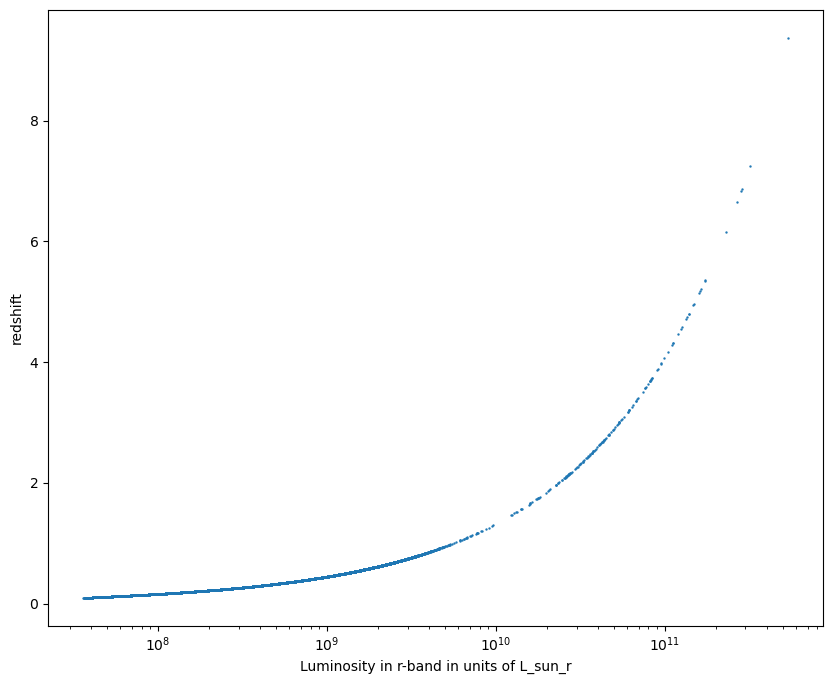

In [370]:
# now plot the inverse:

# from here we can get the z_max values, i.e. the maximum redshift at a certain luminosity that an object could be detected

# inverse is as above

def poly2d_inverse(x, a,h,k):
    return np.sqrt((x-k)/a)+h

a = coefs_LUM_LIM_95[0]
b = coefs_LUM_LIM_95[1]
c = coefs_LUM_LIM_95[2]
h = -b/(2*a)
k = c-a*h**2
inverted_coefs_95 = [a,h,k]

fig, ax = plt.subplots(figsize = (10,8))

#ax.scatter(LUM_LIM_95/(L_sun_z*10**(-7)), center_z, s = 3, color = "red", label ="Calculated luminosity limits, including a offseted z-band magnitude limit")

ax.scatter(ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r*10**(-7)), poly2d_inverse(ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r*10**(-7)), *inverted_coefs_95), s = 0.5)
#ax.vlines(LUM_LIM_95[stop_at-1]/(L_sun_z*10**(-7)), 0, 1, label = "limit of fit")


ax.set_xlabel("Luminosity in r-band in units of L_sun_r")
ax.set_ylabel("redshift")
ax.set_xscale("log")
#ax.set_ylim(0,1)
#ax.set_xlim(10,10**5)
#ax.legend()
plt.show()

In [371]:
z_max_i = np.array(poly_inverse(ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r*10**(-7)), *inverted_coefs_95))

In [372]:
z_max_i[:5], len(ztile_cat_grouped_by_AppMag)

(array([0.23180348, 0.19965879, 0.20619604, 0.21016679, 0.13385506]), 116476)

In [373]:
ztile_cat_z_max = hstack([ztile_cat_grouped_by_AppMag, Table({"z_max": z_max_i})])

In [374]:
ztile_cat_z_max[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64
39627835916159877,main,bright,20220212,0.23428330596704042,1.443498528161678e-05,0,GALAXY,171.14972043569097,1.92477068287446,7.353448,15.84911,23.749014,20.3337724506855,19.499987959861755,19.060885906219482,4.035351851665228e+36,1.249202178789381e+36,4.908792970050321e+36,1.2491883259921112e+36,0.23180347602811685
39627666977982573,main,bright,20220428,0.20157941103755833,1.083824890052584e-05,0,GALAXY,176.56867538190875,-4.981347833087403,8.609719,15.849189,23.325424,20.162527561187744,19.4999822974205,19.0804260969162,2.8281714242868873e+36,8.914056784326203e+35,3.502798171009178e+36,8.913911444683167e+35,0.19965879168114414
39627823786233784,main,bright,20220202,0.20824350213383092,9.564463444010136e-05,0,GALAXY,168.17077944574612,1.5950422798573112,4.9256334,15.849355,34.00256,20.768844783306122,19.499970972537994,18.67122083902359,4.433535407625294e+36,9.58610704831899e+35,3.7668425060952035e+36,9.585850764483878e+35,0.20619604409022352
39627715116009935,main,bright,20220307,0.2122874558546436,0.00017191232459495677,0,GALAXY,170.87479636907145,-3.1225857124801504,4.6221576,15.849775,32.721992,20.83788812160492,19.49994206428528,18.712900578975677,4.4542964314349503e+36,1.0008169874419087e+36,3.932586581295464e+36,1.000763584506429e+36,0.21016678644357106
39627817830322361,main,bright,20220329,0.13567196470711493,7.6202518639822085e-06,0,GALAXY,173.24658341521794,1.3128592157285623,10.536563,15.849862,22.040632,19.943252503871918,19.4999361038208,19.141939878463745,1.1182669435643109e+36,3.7302603467223355e+35,1.4657516244900027e+36,3.7300408252868616e+35,0.1338550578875149


In [375]:
#only allow redshifts above 0.1
ztile_cat_z_max = ztile_cat_z_max[ztile_cat_z_max["z_max"] >0.1]

In [376]:
ztile_cat_z_max[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64
39627835916159877,main,bright,20220212,0.23428330596704042,1.443498528161678e-05,0,GALAXY,171.14972043569097,1.92477068287446,7.353448,15.84911,23.749014,20.3337724506855,19.499987959861755,19.060885906219482,4.035351851665228e+36,1.249202178789381e+36,4.908792970050321e+36,1.2491883259921112e+36,0.23180347602811685
39627666977982573,main,bright,20220428,0.20157941103755833,1.083824890052584e-05,0,GALAXY,176.56867538190875,-4.981347833087403,8.609719,15.849189,23.325424,20.162527561187744,19.4999822974205,19.0804260969162,2.8281714242868873e+36,8.914056784326203e+35,3.502798171009178e+36,8.913911444683167e+35,0.19965879168114414
39627823786233784,main,bright,20220202,0.20824350213383092,9.564463444010136e-05,0,GALAXY,168.17077944574612,1.5950422798573112,4.9256334,15.849355,34.00256,20.768844783306122,19.499970972537994,18.67122083902359,4.433535407625294e+36,9.58610704831899e+35,3.7668425060952035e+36,9.585850764483878e+35,0.20619604409022352
39627715116009935,main,bright,20220307,0.2122874558546436,0.00017191232459495677,0,GALAXY,170.87479636907145,-3.1225857124801504,4.6221576,15.849775,32.721992,20.83788812160492,19.49994206428528,18.712900578975677,4.4542964314349503e+36,1.0008169874419087e+36,3.932586581295464e+36,1.000763584506429e+36,0.21016678644357106
39627817830322361,main,bright,20220329,0.13567196470711493,7.6202518639822085e-06,0,GALAXY,173.24658341521794,1.3128592157285623,10.536563,15.849862,22.040632,19.943252503871918,19.4999361038208,19.141939878463745,1.1182669435643109e+36,3.7302603467223355e+35,1.4657516244900027e+36,3.7300408252868616e+35,0.1338550578875149


In [377]:
np.min(ztile_cat_z_max["Z"]), np.max(ztile_cat_z_max["Z"])

(0.10000133480204226, 1.6972743730127822)

In [378]:
V_max_i = [V_max(area, z_min_data, ztile_cat_z_max["z_max"][q]) for q in range(len(ztile_cat_z_max))]

In [379]:
len(V_max_i)

116389

In [380]:
len(ztile_cat_z_max)

116389

In [381]:
V_max_i[:5]

[<Quantity 32337362.21938804 Mpc3>,
 <Quantity 18708707.94421668 Mpc3>,
 <Quantity 21089012.82156141 Mpc3>,
 <Quantity 22627237.51114151 Mpc3>,
 <Quantity 3406198.74218871 Mpc3>]

In [382]:
ztile_wVmax = hstack([ztile_cat_z_max, Table({"V_MAX": V_max_i})])

In [383]:
ztile_wVmax

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max,V_MAX
,,,,,,,,,,,,,,,,,,,,,Mpc3
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
39627835916159877,main,bright,20220212,0.23428330596704042,1.443498528161678e-05,0,GALAXY,171.14972043569097,1.92477068287446,7.353448,15.84911,23.749014,20.3337724506855,19.499987959861755,19.060885906219482,4.035351851665228e+36,1.249202178789381e+36,4.908792970050321e+36,1.2491883259921112e+36,0.23180347602811685,32337362.21938804
39627666977982573,main,bright,20220428,0.20157941103755833,1.083824890052584e-05,0,GALAXY,176.56867538190875,-4.981347833087403,8.609719,15.849189,23.325424,20.162527561187744,19.4999822974205,19.0804260969162,2.8281714242868873e+36,8.914056784326203e+35,3.502798171009178e+36,8.913911444683167e+35,0.19965879168114414,18708707.944216684
39627823786233784,main,bright,20220202,0.20824350213383092,9.564463444010136e-05,0,GALAXY,168.17077944574612,1.5950422798573112,4.9256334,15.849355,34.00256,20.768844783306122,19.499970972537994,18.67122083902359,4.433535407625294e+36,9.58610704831899e+35,3.7668425060952035e+36,9.585850764483878e+35,0.20619604409022352,21089012.821561415
39627715116009935,main,bright,20220307,0.2122874558546436,0.00017191232459495677,0,GALAXY,170.87479636907145,-3.1225857124801504,4.6221576,15.849775,32.721992,20.83788812160492,19.49994206428528,18.712900578975677,4.4542964314349503e+36,1.0008169874419087e+36,3.932586581295464e+36,1.000763584506429e+36,0.21016678644357106,22627237.511141505
39627817830322361,main,bright,20220329,0.13567196470711493,7.6202518639822085e-06,0,GALAXY,173.24658341521794,1.3128592157285623,10.536563,15.849862,22.040632,19.943252503871918,19.4999361038208,19.141939878463745,1.1182669435643109e+36,3.7302603467223355e+35,1.4657516244900027e+36,3.7300408252868616e+35,0.1338550578875149,3406198.742188713
39627751249939488,main,bright,20211219,0.17741879029265198,4.038567067795509e-06,0,GALAXY,164.62507716662276,-1.4904943931161718,7.6938553,15.849929,28.825605,20.28463989496231,19.499931633472443,18.850553929805756,2.6320754066270643e+36,6.713351588443035e+35,2.6379031399701054e+36,6.712928876107825e+35,0.1759319147037528,11527266.186348546
39627678826889600,main,bright,20220202,0.27617559570485434,5.8314291574574656e-05,0,GALAXY,164.7234944064917,-4.579779678579022,4.7597575,15.850132,34.427982,20.806037932634354,19.49991762638092,18.657720983028412,8.501453615449641e+36,1.8155435833936314e+36,7.133793412755478e+36,1.8154058453115433e+36,0.27349767777109085,58451554.20526225
39627805838803573,sv3,bright,20210412,0.22758025299510903,0.00013580970085046507,0,GALAXY,178.28342115643846,0.7625343731361771,4.905727,15.850238,32.08448,20.77324151992798,19.499910473823547,18.734262585639954,5.1062420726384683e+36,1.1701307463239285e+36,4.5977502802352333e+36,1.170034265233625e+36,0.22520275028985248,29126213.071017608


In [384]:
lower_limit_lum = np.min(ztile_wVmax["LUM_R"])
upper_limit_lum = np.max(ztile_wVmax["LUM_R"])
print("lower and upper limit of LUM_R: ", lower_limit_lum, upper_limit_lum)

num_of_lum_bins = 100

lum_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), num_of_lum_bins, endpoint = True)

print("num of bins", len(lum_bins))
print(lum_bins[0:10])

lower and upper limit of LUM_R:  2.184661522228956e+35 2.884375447176123e+39
num of bins 100
[2.18466152e+35 2.40440191e+35 2.64624451e+35 2.91241243e+35
 3.20535238e+35 3.52775720e+35 3.88259054e+35 4.27311418e+35
 4.70291796e+35 5.17595281e+35]


In [385]:
len(lum_bins)

100

In [386]:
def calc_phi_j(V_max_i, lum_bins):
    
    phi_j = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    for q in range(len(phi_j)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX"]
        one_ov_dat = [1/vmax for vmax in dat]
        phi_j[cnt] = np.sum(one_ov_dat)
        cnt += 1
    return phi_j

In [387]:
phi_j = calc_phi_j(V_max_i, lum_bins)

In [388]:
len(phi_j)

99

In [389]:
phi_j[:5]

[0.0033789874240451475,
 0.0006199706157688822,
 0.000383929747640262,
 0.0003419062296319613,
 0.00033664037584213544]

In [390]:
center_lum_bins = lum_bins[1:]-(lum_bins[2]-lum_bins[1])/2

In [391]:
len(center_lum_bins)

99

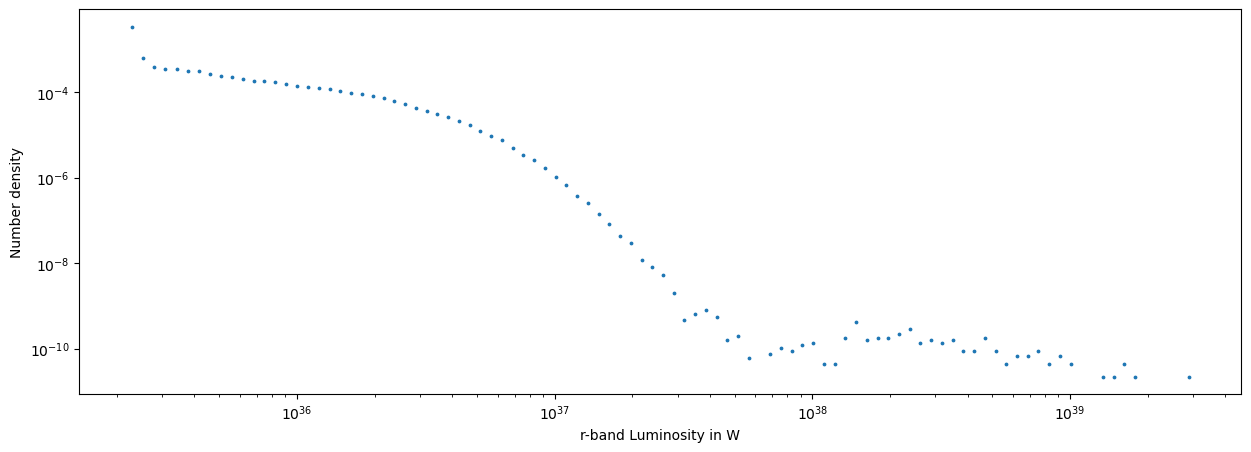

In [392]:
fig, ax = plt.subplots(figsize = (15,5))

ax.scatter(center_lum_bins, phi_j, s = 3)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r-band Luminosity in W")
ax.set_ylabel("Number density")

plt.show()

In [393]:
# Fit a schechter function to the data
# for this we need to go from the Luminosities back to the magnitudes...

In [458]:
def M_r(L_r):
    return -2.5*np.log10(L_r/(L_sun_r))

In [395]:
len(center_lum_bins), len(phi_j)

(99, 99)

In [396]:
center_lum_bins, phi_j = np.array(center_lum_bins), np.array(phi_j)

In [397]:
center_lum_bins.shape, phi_j.shape

((99,), (99,))

In [398]:
center_lum_bins, phi_j

(array([2.28348061e+35, 2.52532321e+35, 2.79149113e+35, 3.08443108e+35,
        3.40683590e+35, 3.76166924e+35, 4.15219288e+35, 4.58199666e+35,
        5.05503151e+35, 5.57564575e+35, 6.14862507e+35, 6.77923652e+35,
        7.47327693e+35, 8.23712619e+35, 9.07780591e+35, 1.00030439e+36,
        1.10213454e+36, 1.21420710e+36, 1.33755228e+36, 1.47330393e+36,
        1.62270991e+36, 1.78714364e+36, 1.96811666e+36, 2.16729252e+36,
        2.38650215e+36, 2.62776060e+36, 2.89328561e+36, 3.18551799e+36,
        3.50714406e+36, 3.86112033e+36, 4.25070069e+36, 4.67946632e+36,
        5.15135859e+36, 5.67071533e+36, 6.24231067e+36, 6.87139893e+36,
        7.56376294e+36, 8.32576719e+36, 9.16441631e+36, 1.00874195e+37,
        1.11032614e+37, 1.22212799e+37, 1.34517525e+37, 1.48059899e+37,
        1.62964410e+37, 1.79368066e+37, 1.97421654e+37, 2.17291132e+37,
        2.39159146e+37, 2.63226717e+37, 2.89715082e+37, 3.18867734e+37,
        3.50952655e+37, 3.86264782e+37, 4.25128718e+37, 4.679017

In [459]:
fit_data = hstack([Table({"LUM": center_lum_bins}), Table({"ABS_MAG_R": M_r(center_lum_bins)}), Table({"N": phi_j})])

In [460]:
fit_data

LUM,ABS_MAG_R,N
float64,float64,float64
2.2834806149310422e+35,-1.5669089160984204,0.0033789874240451475
2.5253232130339993e+35,-1.6762080203837837,0.0006199706157688822
2.7914911295943966e+35,-1.7850062236753232,0.000383929747640262
3.0844310845974057e+35,-1.8933532714340857,0.0003419062296319613
3.40683589711617e+35,-2.001293629971557,0.00033664037584213544
3.7616692387618084e+35,-2.108867107425843,0.00031855358568425485
4.152192876916639e+35,-2.216109390997946,0.0003041666946864758
4.581996658180142e+35,-2.323052513568746,0.00025757623201017873
5.055031507648414e+35,-2.429725260457079,0.00024239691664923224


In [402]:
fit_data = fit_data[fit_data["N"] != 0]

In [429]:
fit_data[:55]

LUM,ABS_MAG_R,N
float64,float64,float64
2.2834806149310422e+35,-19.06690891609842,0.0033789874240451475
2.5253232130339993e+35,-19.176208020383783,0.0006199706157688822
2.7914911295943966e+35,-19.285006223675325,0.000383929747640262
3.0844310845974057e+35,-19.393353271434087,0.0003419062296319613
3.40683589711617e+35,-19.501293629971556,0.00033664037584213544
3.7616692387618084e+35,-19.608867107425844,0.00031855358568425485
4.152192876916639e+35,-19.716109390997946,0.0003041666946864758
4.581996658180142e+35,-19.823052513568747,0.00025757623201017873
5.055031507648414e+35,-19.92972526045708,0.00024239691664923224


In [404]:
np.array(fit_data["N"])

array([3.37898742e-03, 6.19970616e-04, 3.83929748e-04, 3.41906230e-04,
       3.36640376e-04, 3.18553586e-04, 3.04166695e-04, 2.57576232e-04,
       2.42396917e-04, 2.19399301e-04, 2.04998060e-04, 1.81286555e-04,
       1.80722984e-04, 1.67241029e-04, 1.54613614e-04, 1.40768646e-04,
       1.32550968e-04, 1.22589501e-04, 1.15261278e-04, 1.02942252e-04,
       9.34623680e-05, 8.87949842e-05, 8.21787313e-05, 7.13752283e-05,
       6.02137361e-05, 5.22225881e-05, 4.20849471e-05, 3.59389521e-05,
       3.13153267e-05, 2.61448853e-05, 2.12688778e-05, 1.67752065e-05,
       1.25584519e-05, 9.55387401e-06, 7.59340258e-06, 4.94534582e-06,
       3.44721715e-06, 2.55457985e-06, 1.69683818e-06, 1.03265684e-06,
       6.61905257e-07, 3.76356113e-07, 2.49779280e-07, 1.40639119e-07,
       8.07482018e-08, 4.34830474e-08, 2.99424841e-08, 1.16683101e-08,
       8.09158280e-09, 5.24723886e-09, 2.00837483e-09, 4.62417152e-10,
       6.54103063e-10, 7.89905324e-10, 5.46059529e-10, 1.60186115e-10,
      

In [456]:
# get model
Schechter = models.Schechter1D()
# set fitting algorithm
fit_alg = fitting.LMLSQFitter() # only this Fitter is able to fit, all others from here: https://docs.astropy.org/en/stable/modeling/fitting.html fail
# perform fit

schechter_fit = fit_alg(Schechter, np.array(fit_data["ABS_MAG_R"][2:50]), np.array(fit_data["N"][2:50]))

print(schechter_fit)

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           phi_star             m_star              alpha       
    --------------------- ------------------ -------------------
    8.949790667322127e-05 -22.10067094465393 -1.6176433458355224


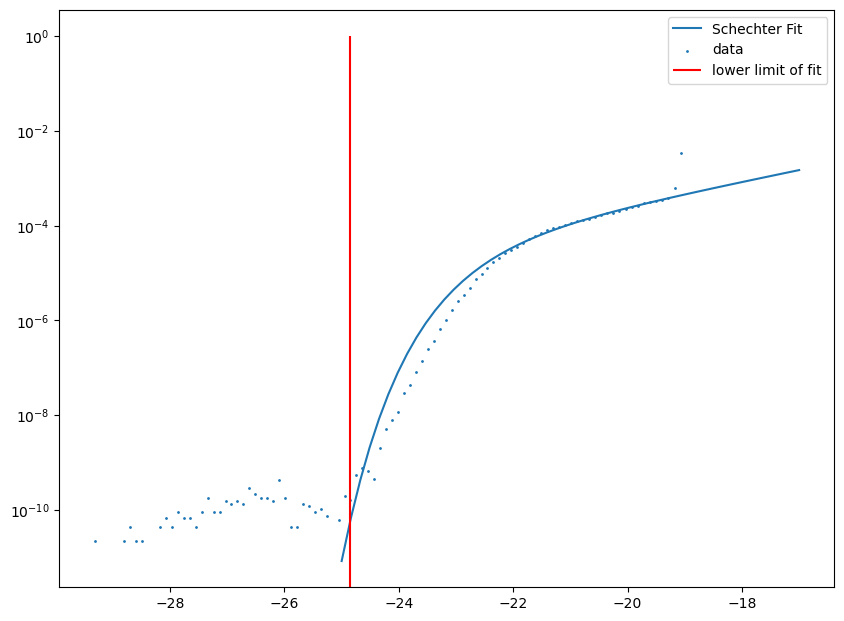

In [457]:
fig, ax = plt.subplots(figsize = (10,7.5))

x = np.linspace(-25, -17)

ax.plot(x, schechter_fit(x), label = "Schechter Fit")
ax.scatter(np.array(fit_data["ABS_MAG_R"]), np.array(fit_data["N"]), label = "data", s = 1)
ax.vlines(fit_data["ABS_MAG_R"][55], 0,1, label = "lower limit of fit", color = "red")


ax.set_yscale('log')
#ax.set_ylim(10**-23, 10**-1)
ax.legend()
plt.show()